#### Importing Libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.transform import resize
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import os
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2


#### Loading Dataset

In [11]:
# Defining dataset path and categories
dataset_path = r'D:\project code\Data'

# Defining the categories and subcategories 
categories = {
    'Corn_Blight_leaves': 'corn',
    'Corn_Common_Rust_leaves': 'corn',
    'Corn_Gray_Spot_leaves': 'corn',
    'Corn_Healthy_leaves': 'corn',
    'Potato_Early_blight_leaves': 'potato',
    'Potato_Healthy_leaves': 'potato',
    'Potato_Late_blight_leaves': 'potato',
    'Tomato_Bacterial_spot_leaves': 'tomato',
    'Tomato_Black_mold_leaves': 'tomato',
    'Tomato_Gray_spot_leaves': 'tomato',
    'Tomato_Healthy_leaves': 'tomato',
    'Tomato_Late_blight_leaves': 'tomato'
}

# Creating a dictionary to hold counts
image_counts = {subfolder: 0 for subfolder in categories.keys()}

# Counting images in each subfolder
for subfolder, category in categories.items():
    folder_path = os.path.join(dataset_path, subfolder)
    if os.path.exists(folder_path):
        image_counts[subfolder] = len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])
    else:
        print(f"Warning: Subfolder does not exist: {folder_path}")

# Converting the dictionary to a dataframe
df = pd.DataFrame(list(image_counts.items()), columns=['Subfolder', 'Image Count'])
df

,Subfolder,Image Count
0,Corn_Blight_leaves,1146
1,Corn_Common_Rust_leaves,1306
2,Corn_Gray_Spot_leaves,574
3,Corn_Healthy_leaves,1162
4,Potato_Early_blight_leaves,1000
5,Potato_Healthy_leaves,152
6,Potato_Late_blight_leaves,1000
7,Tomato_Bacterial_spot_leaves,704
8,Tomato_Black_mold_leaves,428
9,Tomato_Gray_spot_leaves,537


#### Visualizing the occurence of each category

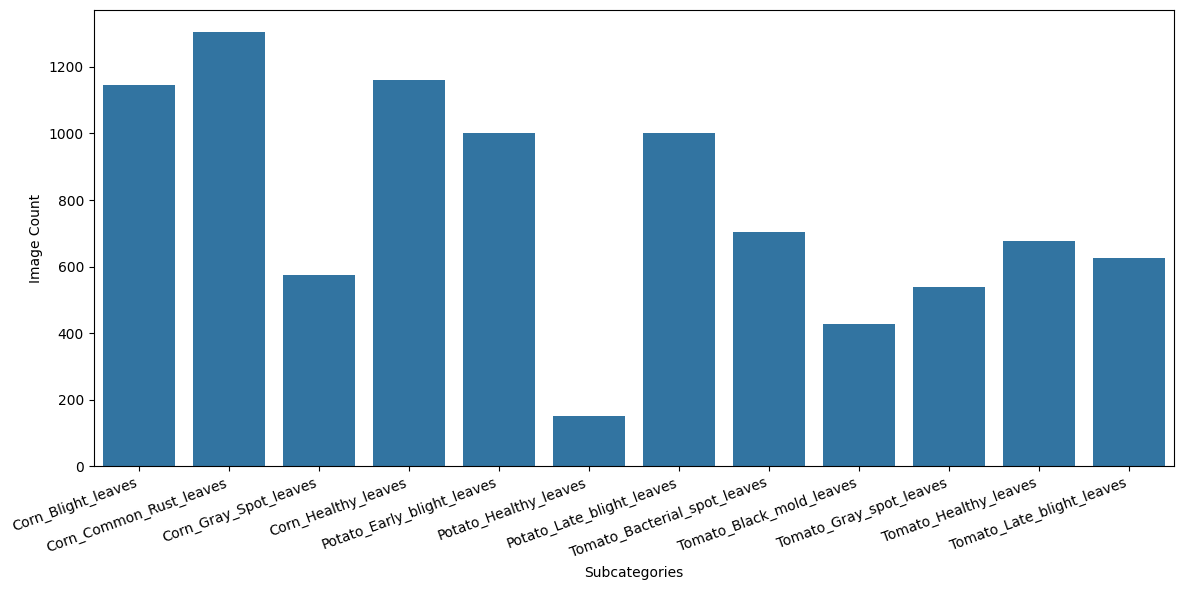

In [12]:
# Setting size of the plot
plt.figure(figsize=(12, 6))

# Creating bar plot
sns.barplot(x='Subfolder', y='Image Count', data=df)

# Rotating x-axis labels for better readability
plt.xticks(rotation=20, ha='right')

# Adding title and labels
plt.xlabel('Subcategories')
plt.ylabel('Image Count')

# Displaying the plot
plt.tight_layout()
plt.show()

#### Dataset Visualization

Checking folder path: D:\project code\Data\Corn_Blight_leaves
Checking folder path: D:\project code\Data\Corn_Common_Rust_leaves
Checking folder path: D:\project code\Data\Corn_Gray_Spot_leaves
Checking folder path: D:\project code\Data\Corn_Healthy_leaves
Checking folder path: D:\project code\Data\Potato_Early_blight_leaves
Checking folder path: D:\project code\Data\Potato_Healthy_leaves
Checking folder path: D:\project code\Data\Potato_Late_blight_leaves
Checking folder path: D:\project code\Data\Tomato_Bacterial_spot_leaves
Checking folder path: D:\project code\Data\Tomato_Black_mold_leaves
Checking folder path: D:\project code\Data\Tomato_Gray_spot_leaves
Checking folder path: D:\project code\Data\Tomato_Healthy_leaves
Checking folder path: D:\project code\Data\Tomato_Late_blight_leaves


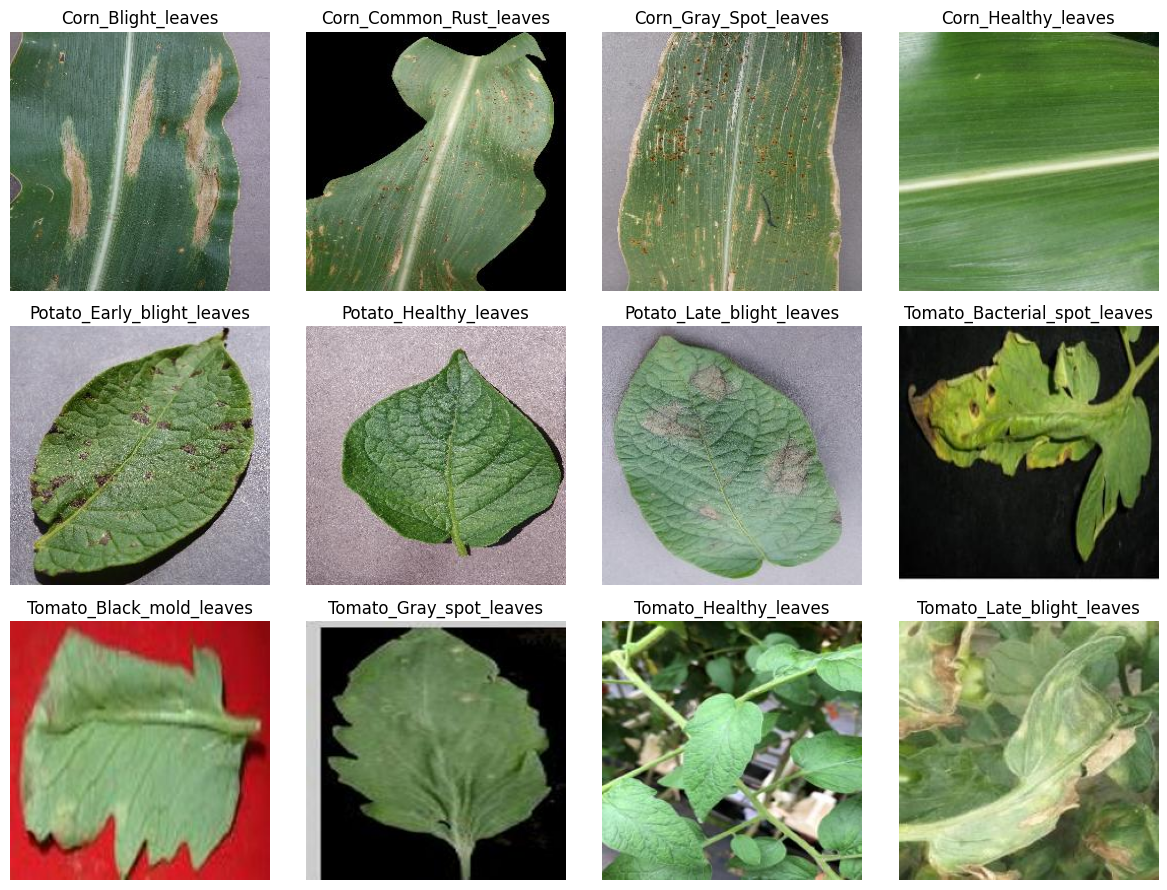

In [13]:
# Defining subfolders
subfolders = list(categories.keys())  

# Preparing list to hold image file path
image_files = []

# Select one image from each subfolder
for subfolder in subfolders:
    folder_path = os.path.join(dataset_path, subfolder)
    print(f"Checking folder path: {folder_path}")   # Debugging line to check paths
    if os.path.isdir(folder_path):  
        image_list = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]
        if image_list:
            # Selecting a random image from the list
            selected_image = random.choice(image_list)
            image_files.append(os.path.join(folder_path, selected_image))
        else:
            print(f"Warning: No images found in folder: {folder_path}")
    else:
        print(f"Warning: Subfolder does not exist: {folder_path}")

# Checking if we have enough images to plot
if len(image_files) < 12:
    print(f"Warning: Fewer images found than expected. Only {len(image_files)} images will be displayed.")

# Ploting the images in a grid
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for ax, img_path in zip(axes.flatten(), image_files):
    try:
        img = imread(img_path)
        ax.imshow(img)
        ax.set_title(os.path.basename(os.path.dirname(img_path)))
        ax.axis('off')
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        ax.set_title("Error")
        ax.axis('off')

plt.tight_layout()
plt.show()


#### Dataset Preprocessing

In [9]:
# Initializing lists to store images and their labels
images_list = []
labels_list = []

# Defining a common size for image resizing
pixels = 128
common_size = (pixels, pixels)  

# Iterating through each category and subfolder
for subfolder, category in categories.items():
    subfolder_path = os.path.join(dataset_path, subfolder)
    
    # Iterating through each image in subfolder
    for img_file in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, img_file)
        
        try:
            # Reading image
            img = imread(img_path)
            
            # Resizing image to a common size
            img_resized = resize(img, common_size)
            
            # Ensuring each image has 3 channels (RGB)
            if img_resized.ndim == 2:
                img_resized = np.stack((img_resized,) * 3, axis=-1)
            elif img_resized.shape[2] == 1:
                img_resized = np.concatenate([img_resized] * 3, axis=-1)

            # Updating image and label lists
            images_list.append(img_resized)
            labels_list.append(subfolder)
            
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            # Handle the error as needed (e.g., skip the image)

# Check for inconsistent image shapes
filtered_images = []
for img in images_list:
    if img.shape == (pixels, pixels, 3):
        filtered_images.append(img)
    else:
        print(f'image with shape {img.shape} filtered out')
images_list = filtered_images

shapes = [img.shape for img in images_list]
unique_shapes = set(shapes)
print("Unique image shapes:", unique_shapes)

images = np.array([img for img in images_list if img.shape == (pixels, pixels, 3)])
labels = np.array([label for img, label in zip(images_list, labels_list) if img.shape == (pixels, pixels, 3)])

# Normalizing images between 0 and 1
images = images.astype(np.float16) / 255.0

# Label encoding
label_encoder = LabelEncoder() 
labels_encoded = label_encoder.fit_transform(labels)

# Printing unique labels to verify encoding
print("Unique labels after encoding:", np.unique(labels_encoded))

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=10)

# Reshaping images
x_train = x_train.reshape(-1, pixels, pixels, 3)
x_test = x_test.reshape(-1, pixels, pixels, 3)

# Converting labels to one-hot encoded vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Printing shapes to verify the split and normalization
print("Training data shape (images):", x_train.shape)
print("Testing data shape (images):", x_test.shape)
print("Training data shape (labels):", y_train.shape)
print("Testing data shape (labels):", y_test.shape)

# Checking the number of total images
total_images = len(labels)
print("The total number of images: ", total_images)

image with shape (128, 128, 4) filtered out
image with shape (128, 128, 4) filtered out
image with shape (128, 128, 4) filtered out
image with shape (128, 128, 4) filtered out
image with shape (128, 128, 4) filtered out
Unique image shapes: {(128, 128, 3)}
Unique labels after encoding: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Training data shape (images): (7447, 128, 128, 3)
Testing data shape (images): (1862, 128, 128, 3)
Training data shape (labels): (7447, 12)
Testing data shape (labels): (1862, 12)
The total number of images:  9309


#### Train/Test Data Overview

In [14]:
# Checking the number of images of each label in training and testing data
train_labels_count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
test_labels_count = np.unique(np.argmax(y_test, axis=1), return_counts=True)

# Creating a dataframe with columns as subcategory names and rows as occurrences
subcategory_names = label_encoder.inverse_transform(train_labels_count[0])

train_counts = dict(zip(subcategory_names, train_labels_count[1]))
test_counts = dict(zip(subcategory_names, test_labels_count[1]))

# Creating seaparate dataframe for train and test counts
train_df = pd.DataFrame.from_dict(train_counts, orient='index', columns=['Train Count']).reset_index()
train_df = train_df.rename(columns={'index': 'Subcategory'})

test_df = pd.DataFrame.from_dict(test_counts, orient='index', columns=['Test Count']).reset_index()
test_df = test_df.rename(columns={'index': 'Subcategory'})

# Merging train and test counts into a single dataframe
counts_df = pd.merge(train_df, test_df, on='Subcategory', how='outer').fillna(0)
counts_df = counts_df.astype({'Train Count': 'int32', 'Test Count': 'int32'})
counts_df

,Subcategory,Train Count,Test Count
0,Corn_Blight_leaves,904,242
1,Corn_Common_Rust_leaves,1046,260
2,Corn_Gray_Spot_leaves,464,110
3,Corn_Healthy_leaves,918,244
4,Potato_Early_blight_leaves,789,211
5,Potato_Healthy_leaves,116,36
6,Potato_Late_blight_leaves,812,188
7,Tomato_Bacterial_spot_leaves,581,123
8,Tomato_Black_mold_leaves,345,83
9,Tomato_Gray_spot_leaves,425,112


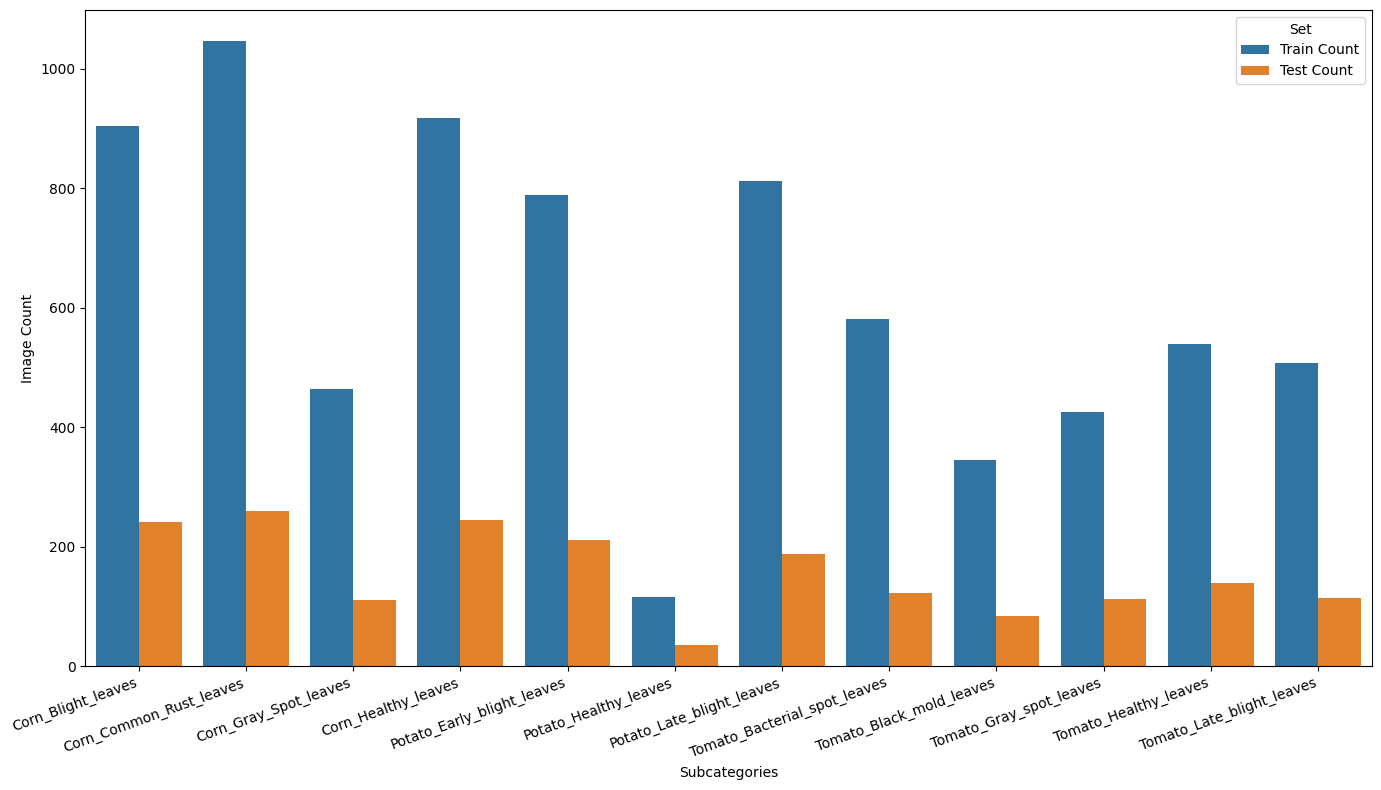

In [15]:
# Set the size of the plot
plt.figure(figsize=(14, 8))

# Creating the grouped bar plot
counts_df_melted = counts_df.melt(id_vars='Subcategory', value_vars=['Train Count', 'Test Count'], var_name='Set', value_name='Count')

sns.barplot(x='Subcategory', y='Count', hue='Set', data=counts_df_melted)

# Rotating x-axis labels for better readability
plt.xticks(rotation=20, ha='right')

# Adding title and labels
plt.xlabel('Subcategories')
plt.ylabel('Image Count')

# Displaying plot
plt.tight_layout()
plt.show()

#### Model Architecture 

In [7]:
# Initializing CNN

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(pixels, pixels, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation='relu', input_shape=(pixels, pixels, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(128, activation= 'relu'),
    Dropout(0.2),
    
    Dense(len(categories), activation='softmax')
])

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Setting callbacks to monitor validation loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,530,540 (9.65 MB)

 Trainable params: 2,530,028 (9.65 MB)

 Non-trainable params: 512 (2.00 KB)

#### Model Training



Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - accuracy: 0.3462 - loss: 2.3983 - val_accuracy: 0.1221 - val_loss: 3.2032 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 432ms/step - accuracy: 0.6244 - loss: 1.2023 - val_accuracy: 0.1221 - val_loss: 5.0231 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 417ms/step - accuracy: 0.6913 - loss: 0.9465 - val_accuracy: 0.1221 - val_loss: 5.7917 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 409ms/step - accuracy: 0.7453 - loss: 0.7642 - val_accuracy: 0.1221 - val_loss: 5.9243 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 394ms/step - accuracy: 0.7775 - loss: 0.6501 - val_accuracy: 0.1221 - val_loss: 4.8091 - learning_rate: 1.0000e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 377ms/step - accuracy: 0.8044 - loss: 0.5712 - val_accuracy: 0.1879 - val_loss: 4.0431 - learning_rate: 1.0000e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 378ms/step - acc

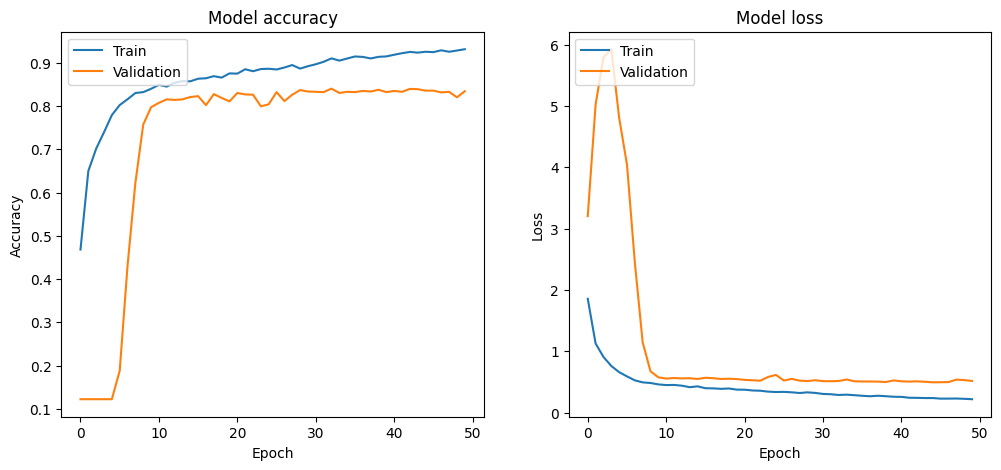

In [8]:
# Spliting training data further into training and validation sets
x_training, x_val, y_training, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Starting model training 
history = model.fit(x_training, y_training, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks= [reduce_lr, early_stopping] )


# Evaluating model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

# fucntion to plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_history(history)

#### Model Evalution

In [9]:
# Class probabilities
y_predicted_prob = model.predict(x_test)
y_predicted_prob

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step


array([[6.72885335e-06, 8.22170387e-06, 5.84753138e-07, ...,
        2.92578134e-05, 9.99938488e-01, 7.58932947e-06],
       [2.02987373e-01, 1.00336801e-02, 8.40408951e-02, ...,
        2.84447670e-01, 3.40109598e-03, 2.93434471e-01],
       [5.69939721e-06, 4.22678277e-05, 1.83669297e-04, ...,
        6.80694298e-04, 5.80646883e-07, 8.98009341e-04],
       ...,
       [9.98210669e-01, 5.86482602e-05, 1.53524056e-03, ...,
        2.98972082e-05, 5.63379363e-05, 5.23017479e-06],
       [1.23123848e-03, 2.14967931e-05, 8.86607158e-05, ...,
        1.22226047e-04, 1.05726795e-04, 8.86712878e-05],
       [5.59378900e-02, 1.81662980e-02, 1.55042682e-03, ...,
        8.23308229e-02, 3.15941423e-01, 8.35584551e-02]], dtype=float32)

In [11]:
#converting class probabilites into class prediction
predicted_class = np.argmax(y_predicted_prob, axis=1)
predicted_class

array([10, 11,  3, ...,  0,  6,  7], dtype=int64)

In [12]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [13]:
# converting y_test from one hot encoding to class labels
y_test_class = np.argmax(y_test, axis=1)
y_test_class

array([10,  8,  3, ...,  0,  6,  0], dtype=int64)

In [14]:
# Class labels for confusion matrix
class_labels = list(categories.keys())
class_labels

['Corn_Blight_leaves',
 'Corn_Common_Rust_leaves',
 'Corn_Gray_Spot_leaves',
 'Corn_Healthy_leaves',
 'Potato_Early_blight_leaves',
 'Potato_Healthy_leaves',
 'Potato_Late_blight_leaves',
 'Tomato_Bacterial_spot_leaves',
 'Tomato_Black_mold_leaves',
 'Tomato_Gray_spot_leaves',
 'Tomato_Healthy_leaves',
 'Tomato_Late_blight_leaves']

In [15]:
conf_matrix = confusion_matrix(y_test_class, predicted_class)
conf_matrix

array([[186,   2,  37,   3,   0,   0,   3,   1,   1,   1,   4,   4],
       [  9, 237,   8,   2,   0,   0,   0,   1,   1,   2,   0,   0],
       [ 19,   2,  85,   0,   0,   0,   0,   1,   0,   1,   1,   1],
       [  1,   0,   0, 239,   1,   0,   0,   0,   0,   0,   0,   3],
       [  0,   0,   0,   1, 200,   0,  10,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   2,  29,   5,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   7,   0, 181,   0,   0,   0,   0,   0],
       [  0,   3,   1,   1,   0,   0,   0,  90,  10,   9,   1,   8],
       [  1,   6,   0,   1,   0,   0,   0,  14,  53,   3,   0,   5],
       [  4,   3,   3,   0,   1,   0,   1,  14,   7,  59,   0,  20],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1, 135,   3],
       [  1,   2,   0,   1,   1,   0,   0,  20,   7,   9,   3,  70]],
      dtype=int64)

In [16]:
# Display confusion matrix with class labels
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
conf_matrix_df

,Corn_Blight_leaves,Corn_Common_Rust_leaves,Corn_Gray_Spot_leaves,Corn_Healthy_leaves,Potato_Early_blight_leaves,Potato_Healthy_leaves,Potato_Late_blight_leaves,Tomato_Bacterial_spot_leaves,Tomato_Black_mold_leaves,Tomato_Gray_spot_leaves,Tomato_Healthy_leaves,Tomato_Late_blight_leaves
Corn_Blight_leaves,186,2,37,3,0,0,3,1,1,1,4,4
Corn_Common_Rust_leaves,9,237,8,2,0,0,0,1,1,2,0,0
Corn_Gray_Spot_leaves,19,2,85,0,0,0,0,1,0,1,1,1
Corn_Healthy_leaves,1,0,0,239,1,0,0,0,0,0,0,3
Potato_Early_blight_leaves,0,0,0,1,200,0,10,0,0,0,0,0
Potato_Healthy_leaves,0,0,0,0,2,29,5,0,0,0,0,0
Potato_Late_blight_leaves,0,0,0,0,7,0,181,0,0,0,0,0
Tomato_Bacterial_spot_leaves,0,3,1,1,0,0,0,90,10,9,1,8
Tomato_Black_mold_leaves,1,6,0,1,0,0,0,14,53,3,0,5
Tomato_Gray_spot_leaves,4,3,3,0,1,0,1,14,7,59,0,20


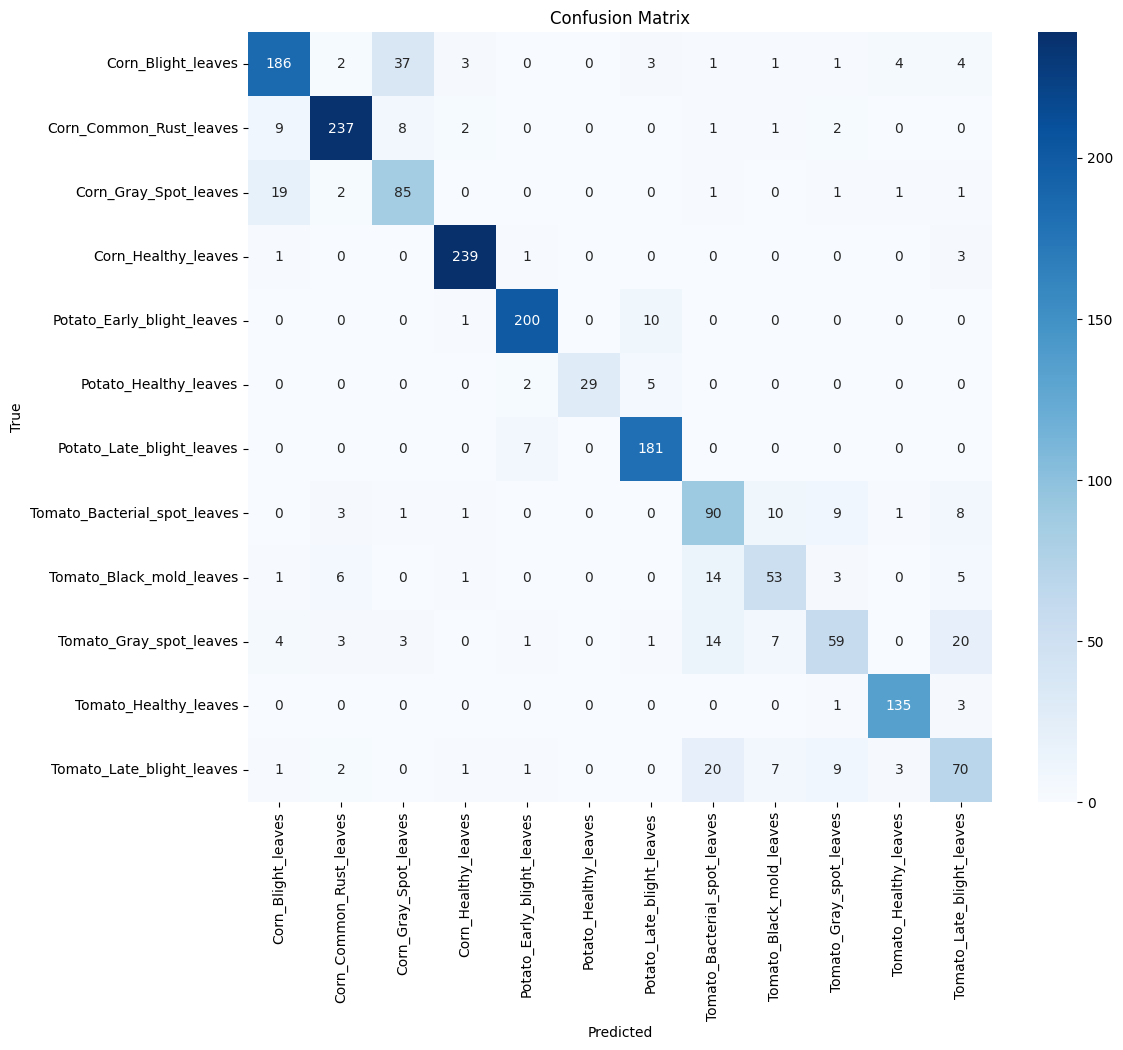

In [17]:
# Plotting the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Generating classification report as a dictionary
class_report_dict = classification_report(y_test_class, predicted_class, target_names=class_labels, output_dict=True)

# Converting dictionary to a dataframe
class_report_df = pd.DataFrame(class_report_dict).transpose()

# Saving DataFrame to a CSV file
csv_file_path = 'classification_report.csv'
class_report_df.to_csv(csv_file_path)

print(class_report_df)

                              precision    recall  f1-score      support
Corn_Blight_leaves             0.841629  0.768595  0.803456   242.000000
Corn_Common_Rust_leaves        0.929412  0.911538  0.920388   260.000000
Corn_Gray_Spot_leaves          0.634328  0.772727  0.696721   110.000000
Corn_Healthy_leaves            0.963710  0.979508  0.971545   244.000000
Potato_Early_blight_leaves     0.943396  0.947867  0.945626   211.000000
Potato_Healthy_leaves          1.000000  0.805556  0.892308    36.000000
Potato_Late_blight_leaves      0.905000  0.962766  0.932990   188.000000
Tomato_Bacterial_spot_leaves   0.638298  0.731707  0.681818   123.000000
Tomato_Black_mold_leaves       0.670886  0.638554  0.654321    83.000000
Tomato_Gray_spot_leaves        0.694118  0.526786  0.598985   112.000000
Tomato_Healthy_leaves          0.937500  0.971223  0.954064   139.000000
Tomato_Late_blight_leaves      0.614035  0.614035  0.614035   114.000000
accuracy                       0.839957  0.839957  

In [22]:
# Calculating F1 score
f1 = f1_score(y_test_class, predicted_class, average='weighted')  
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8391
